This Jupyter notebook is code used for the paper PUF Transformer: A transformer based modeling attack on Physical Unclonable Functions (PUF)

This is part of submission for final project for CS284: Deep Learning

This whole jupyter notebook was run with Google Colab Pro. To start training with 4M and 9M dataset make sure that high ram mode is on when using google colab pro as generation of CRPs consumes a lot of RAM.

It is also advised to use fast GPUs such as V100 or A100 to speed up training.

In [ ]:
!pip3 install pypuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 867.9 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of pypuf to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 4.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive # Mount my google drive diretory
drive.mount("/content/gdrive",force_remount=True)
import os # Change directory to CS284 folder in google drive
os.chdir("gdrive/MyDrive/CS284/Project_Experiments/Main/Nbit_experiment")

Mounted at /content/gdrive


The code below shows instantiation of the XOR Arbiter PUF instances. n parameter is the length of the challenges and k is the number of arbiter chains. For example n=32 and k=2 means a 2-XOR 32 bit configuration.

Seed parameter is used for different sets of responses. For example for 2-XOR arbiter PUFs seed=1 and seed=2 have different responses from different challenges.  

In [ ]:
from pypuf.simulation import XORArbiterPUF
#Choose  Which PUF setting desired. n is number of bits, k is equal number of arbiter chains.
puf = XORArbiterPUF(n=32, k=2, seed=1)

#puf = XORArbiterPUF(n=32, k=2, seed=4)
#puf = XORArbiterPUF(n=32, k=3, seed=1)
#puf = XORArbiterPUF(n=32, k=4, seed=1)
#puf = XORArbiterPUF(n=64, k=2, seed=1)

Thee code below generates the datasets used for training and testing.

In [ ]:
#This Generates random decimal numbers that will be later converted to binary to be used as challenges

# importing random module
import random

N=32 # Length of the challenges
total_dataset=2000000 # This is the total number of challenges
# getting numbers from 0 to 100
inputNumbers =range(0,2**N)
# non-repeating using sample() function
decimal_values=random.sample(inputNumbers,total_dataset )
print("10 non-repeating random numbers are:")
print(decimal_values[0:10])


import numpy as np
decimal_values=np.array(decimal_values)
decimal_values=decimal_values.astype(int)


10 non-repeating random numbers are:
[3208077124, 1037364061, 1110098133, 2424003205, 2674069650, 2780340368, 2881498723, 1847595418, 2092717647, 3304981961]


The code below converts the decimal values to binary values that will be used as input to the PUF instantiation. All 0s are converted to -1s as the PUFs generated by PYPUF accepts 1s and -1s as inputs.

In [ ]:
import numpy as np

# Generate an array from 0 to 2^16 - 1
#decimal_values = np.arange(2**32)

# Convert decimal values to binary representation as strings
# Adjust width parameter of np.binary_repr depending on the length of the challenges
binary_strings = [np.binary_repr(value, width=N) for value in decimal_values]

# Convert binary strings to NumPy arrays and replace '0's with -1s and '1' to 1
binary_arrays = [np.array(list(map(lambda x: -1 if x == '0' else 1, binary))) for binary in binary_strings]



challenges=np.array(binary_arrays)
np.random.shuffle(challenges),len(challenges)

(None, 2000000)

In [ ]:
# Inputs the challenges to the PUF and saving response. Counts the number of 1s and -1s of the response. Ideal responses should be around 0.5 ratio of 1s and 0s
response=puf.eval(challenges)
import numpy as np
np.count_nonzero(response==1)/(np.count_nonzero(response==-1)+np.count_nonzero(response==1)),response

(0.5345895, array([-1, -1, -1, ..., -1, -1, -1]))

In [ ]:
import numpy as np

response[response == -1] = 0
np.count_nonzero(response==1),np.count_nonzero(response==0),response

(1069179, 930821, array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
#Splits the dataset to train and test and Creates the dataloader to be used for training
#Divide data to train and test
train_split=0.5; # Change this if you want to adjust the train test split from the generated dataset
dataset_size=total_dataset
end_dataset=1
train_data=challenges[0:int(dataset_size*train_split)]
train_labels=response[0:int(dataset_size*train_split)]
test_data=challenges[int(dataset_size*train_split):int(dataset_size*end_dataset)]
test_labels=response[int(dataset_size*train_split):int(dataset_size*end_dataset)]
# Displaying the shapes of cropped and then processed data data
print("Training data shape:", train_data.shape)
print("Training labels length:", len(train_labels))
print("Test data shape:", test_data.shape)
print("Test labels length:", len(test_labels))

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
# Function combining image and labels by inheriting Dataset
class CombineChallengesandResponses(Dataset):
  def __init__(self,data,labels,transforms=None):
    self.data=data
    self.labels=labels
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    image=self.data[idx]
    label=self.labels[idx]

    if self.transforms is not None:
      image = self.transforms(image)


    return image,label

#create_dataset
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)
PUF_train_data=CombineChallengesandResponses(train_data,train_labels)
PUF_test_data=CombineChallengesandResponses(test_data,test_labels)
len(PUF_train_data),len(PUF_test_data)


#Create Dataloader
train_batch_size=10000
train_data_loader=torch.utils.data.DataLoader(PUF_train_data,batch_size=train_batch_size,shuffle=True,num_workers=4)
test_data_loader=torch.utils.data.DataLoader(PUF_test_data,batch_size=train_batch_size,shuffle=False,num_workers=4)

Training data shape: (1000000, 32)
Training labels length: 1000000
Test data shape: (1000000, 32)
Test labels length: 1000000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#Visualize sample from dataset
chal,resp=PUF_test_data[101]
chal,resp

(array([-1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1,
        -1,  1,  1, -1,  1, -1, -1, -1,  1, -1,  1, -1,  1, -1,  1]),
 0)

In [ ]:
## Device agnostic cuda will be default if available if non device will be CPU

device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Positional Encoding
max_len=16
embedding_dim=16
def create_positional_encoding(max_len):
  pe=torch.zeros(max_len)
  for pos in range(max_len):
    #for i in range (0,embedding_dim,2):
      pe[pos]=math.sin(pos/(10000**((2)/1)))
      #pe[pos]=math.cos(pos/(10000**((2*(i+1))/embedding_dim)))
  pe=pe*10000
  pe=pe.unsqueeze(0) #(1,max_len,embedding_dim)
  return pe.to(device)

# Create input embedding
import math
import torch
from torch import nn







class MSA_in(nn.Module): #Nolayernorm
  def __init__(self,
               num_heads:int=2,
               attn_dropout:float=0,
               input_size:int=64,norm_en:int=0
               ):

    super().__init__()

  #MSA layer
    self.multihead_attn=nn.MultiheadAttention(embed_dim=input_size,num_heads=num_heads,batch_first=True)# batch first output needs to be done to have consistent format.
    self.dropout=nn.Dropout(attn_dropout)
    self.norm_en=norm_en
    self.input_size=input_size
    self.tanh=nn.Tanh()
  def forward(self,x):

    #x=self.mlp(x)
    x = x.to(torch.device(device)).float()
    attn_output,_=self.multihead_attn(query=x,key=x,value=x,need_weights=False)
    #attn_output=self.tanh(attn_output)
    atnn_output=self.dropout(attn_output)


    return attn_output
# Create MLP layer

class MLP(nn.Module):
  def __init__(self,mlp_dropout:float=0.1,input_size:int=32,output_size:int=32,norm_en:int=0):
    super().__init__()

  #Create layer norm layer
    self.norm_en=norm_en
    self.tanh=nn.Tanh()

  #create the MLP
    self.mlp=nn.Sequential(nn.Linear(in_features=input_size,out_features=output_size),nn.Dropout(p=mlp_dropout)) #only one layer
    self.input_size=input_size
  def forward(self,x):
    if (self.norm_en==0):
     layer_norm=nn.LayerNorm(normalized_shape=self.input_size)
     layer_norm(x)

    x=self.mlp(x)
    x=self.tanh(x)


    return x

class MLP_out(nn.Module):
  def __init__(self,mlp_dropout:float=0.1,input_size:int=32,output_size:int=32,norm_en:int=0):
    super().__init__()

  #Create layer norm layer
    self.norm_en=norm_en

  #create the MLP
    self.mlp=nn.Sequential(nn.Linear(in_features=input_size,out_features=output_size),nn.Dropout(p=mlp_dropout)) #only one layer
    self.input_size=input_size
  def forward(self,x):
    if (self.norm_en==0):
     layer_norm=nn.LayerNorm(normalized_shape=self.input_size)
     layer_norm(x)

    x=self.mlp(x)


    return x


class PUFTrans(nn.Module):
  def __init__(self,
               num_heads:int=2,
               input_size:int=16,
               mlp_dropout:float=0.0,
               attn_dropout:float=0.0,
               mlp_ratio:float=0.0
               ,num_transformer_layers:int=1,
               num_lin_layers:int=1
               ):

    super().__init__()
    self.num_heads=num_heads
    self.pe=create_positional_encoding(max_len=input_size)
    self.input_size=input_size
    self.mlp_dropout:float=0.0
    self.attn_dropout:float=0.0
    self.msa1=MSA_in(input_size=input_size,num_heads=num_heads,attn_dropout=attn_dropout)
    self.mlp1=MLP(input_size=input_size,output_size=input_size*mlp_ratio,mlp_dropout=mlp_dropout,norm_en=1)
    self.mlp2=MLP(input_size=input_size*mlp_ratio,output_size=1,mlp_dropout=mlp_dropout,norm_en=1)
    self.linear=nn.Sequential(*[MLP(input_size=input_size*mlp_ratio,output_size=input_size*mlp_ratio,mlp_dropout=mlp_dropout,norm_en=1) for _ in range (num_lin_layers)])

  def forward(self,x):

    x=self.pe+x#*math.sqrt(self.input_size)
    x=self.msa1(x)+x
    x=x.squeeze()
    x=self.mlp1(x)




    x=self.linear(x)
    x=self.mlp2(x)

    return x.squeeze()









In [ ]:
# Import time it for training time checking and printing of total time
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device:torch.device=None):
  total_time=end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

# Function made for accuracy checking
def accuracy_fn(y_target,y_pred):

    correct = (y_target==y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [ ]:
#Training from scratch
from torch.optim.lr_scheduler import CosineAnnealingLR

device="cuda" if torch.cuda.is_available() else "cpu" #device
loss_fn=nn.BCEWithLogitsLoss()#Loss Function

model=PUFTrans(attn_dropout=0.0,mlp_dropout=0.1,num_heads=8,mlp_ratio=8,input_size=32,num_lin_layers=3)
optimizer1=torch.optim.Adam(params=model.parameters(),lr=0.005,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
sigmoid=nn.Sigmoid()

In [ ]:
# Training and Testing Function
def training(model:torch.nn.Module,data_loader:DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer, accuracy_fn,device:torch.device=device):
  train_loss,train_acc=0,0
  model.to(device)
  model.train()

  for batch,(X,y) in enumerate(data_loader):
    X,y=X.float().to(device),y.float().to(device)

    y_pred=model(X)

    loss=loss_fn(y_pred,y)
    y_pred = (sigmoid(y_pred) >= 0.5).float()
    train_loss=train_loss+loss

    train_acc=train_acc+accuracy_fn(y_target=y,y_pred=y_pred)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
  lr_scheduler.step()

  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  print(f"Train Loss:{train_loss:5f}|Train Acc:{train_acc:5f}%")
  return train_loss,train_acc


def testing(data_loader:DataLoader,model:torch.nn.Module,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.float().to(device),y.float().to(device)

      test_pred=model(X)

      test_loss=test_loss+loss_fn(test_pred,y)
      test_pred = (sigmoid(test_pred) >= 0.5).float()
      test_acc=test_acc+accuracy_fn(y_target=y,y_pred=test_pred)

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss,test_acc

In [ ]:
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=300 #epochs
best_loss=300
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_data_loader,model=model,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_data_loader,model=model,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_loss<best_loss):
    best_loss=test_loss
    model.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_loss}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_loss>=best_loss:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_loss}")
model.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss:0.670251|Train Acc:58.955700%
Test loss: 0.65403 | Test accuracy: 61.87%

Epoch:0
New best test loss is 0.6540257930755615. Model Saved
Train Loss:0.652277|Train Acc:61.870200%
Test loss: 0.63994 | Test accuracy: 63.97%

Epoch:1
New best test loss is 0.6399434208869934. Model Saved
Train Loss:0.642617|Train Acc:63.234300%
Test loss: 0.63092 | Test accuracy: 65.22%

Epoch:2
New best test loss is 0.6309235095977783. Model Saved
Train Loss:0.634745|Train Acc:64.355100%
Test loss: 0.62208 | Test accuracy: 66.37%

Epoch:3
New best test loss is 0.6220800876617432. Model Saved
Train Loss:0.626490|Train Acc:65.423300%
Test loss: 0.61165 | Test accuracy: 67.73%

Epoch:4
New best test loss is 0.6116468906402588. Model Saved
Train Loss:0.619083|Train Acc:66.328000%
Test loss: 0.60254 | Test accuracy: 68.85%

Epoch:5
New best test loss is 0.6025431752204895. Model Saved
Train Loss:0.614008|Train Acc:66.997500%
Test loss: 0.59861 | Test accuracy: 69.29%

Epoch:6
New best test loss is 0.5

5914.863446469

In [ ]:
#Installs torchmetrics and runs test loop on the test dataset

!pip install torchmetrics


import mlxtend
mlxtend.__version__
from tqdm.auto import tqdm
y_targets=[]
y_preds=[]
model_load=model
model_load.eval()
with torch.inference_mode():
  for (X,y) in tqdm(test_data_loader):
    X,y= X.float().to(device),y.to(device)
    test_pred=model_load(X)
    y_pred=(sigmoid(test_pred) >= 0.5).float()

    y_targets.append(y.cpu())
    y_preds.append(y_pred.cpu())

y_preds_tensor=torch.cat(y_preds)
y_targets_tensor=torch.cat(y_targets)
y_targets[:10]

import torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#Setups the confusion matrix
confmat= ConfusionMatrix(num_classes=2,task='multiclass')
confmat_tensor=confmat(preds=y_preds_tensor,target=y_targets_tensor)


#fig,ax=plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),class_names=classes,figsize=(10,7))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.8 MB/s eta 0:00:00


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
accuracy=(confmat_tensor[0][0]+confmat_tensor[1][1])*100/sum(sum(confmat_tensor))
confmat_tensor,accuracy

(tensor([[452088,  13323],
         [ 14231, 520358]]),
 tensor(97.2446))

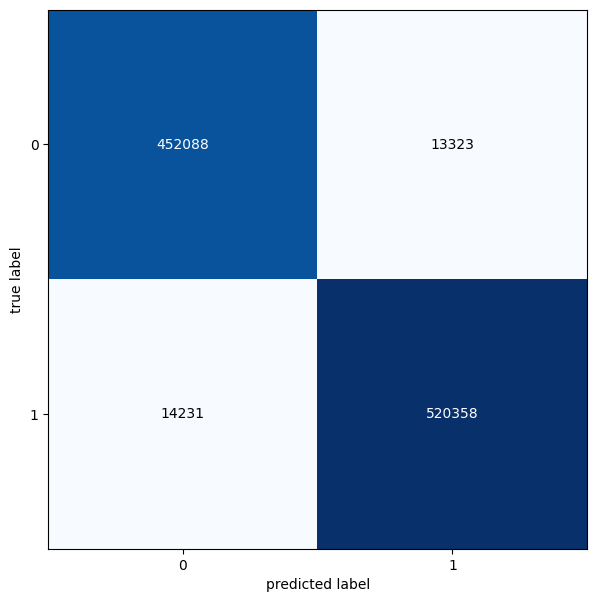

In [ ]:
#Plots the confusion matrix through figure
fig,ax=plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),figsize=(10,7))